# Perform Fisher forecast for LSST-Y1 data constraint on cosmological parameters

In this notebook we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on cosmological parameters from an LSST-Y1 like survey.

## Load the python modules

In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

## Generate the redshift distributions

### Generate source and lens n(z)

We follow S. S. Bourah, et. al. ([arXiv:2203.06124v1](https://arxiv.org/abs/2203.06124)) in using a Smail redshift distribution for galaxies
$$n(z)\propto z^2\mathrm{exp}[-(z/z_0)^\alpha],$$
divided into 5 tomographic bins. For the lens galaxies, we take $(\alpha,z_0) = (.94,.26)$ with an effective number density $n_\mathrm{eff} = 18 \text{ arcmin}^{-2}.$ For the source galaxies, we take $(\alpha,z_0) = (.870,.191)$ and $n_\mathrm{eff} = 11.2\text{ arcmin}^{-2}.$ We then divide each distribution into 5 tomographic bins with an equal number of galaxies, and then convolve each bin with a Gaussian photo-z uncertainty of .05(1+z) for sources and .02(1+z) for lenses.

In [2]:
n_source_total = jc.redshift.smail_nz(2, .870, .191, n_gals_per_arcmin2 = 11.2)
n_lens_total = jc.redshift.smail_nz(2, .94, .26, n_gals_per_arcmin2=18)
#TODO figure out how to convolve these redshift bins w/ Gaussian kernel in some way that's jax-friendly
nzs_s = [jc.redshift.step_fcn(n_source_total, 0, .3926, n_gals_per_arcmin2 = 11.2/5),
         jc.redshift.step_fcn(n_source_total, .3926, .5979, n_gals_per_arcmin2 = 11.2/5),
         jc.redshift.step_fcn(n_source_total, .5979, .829, n_gals_per_arcmin2 = 11.2/5),
         jc.redshift.step_fcn(n_source_total, .829, 1.1694, n_gals_per_arcmin2 = 11.2/5),
         jc.redshift.step_fcn(n_source_total, 1.1694, 10, n_gals_per_arcmin2 = 11.2/5)]
nzs_l = [jc.redshift.step_fcn(n_lens_total, 0, .4509, n_gals_per_arcmin2 = 18/5),
         jc.redshift.step_fcn(n_lens_total, .4509, .6778, n_gals_per_arcmin2 = 18/5),
         jc.redshift.step_fcn(n_lens_total, .6778, .9293, n_gals_per_arcmin2 = 18/5),
         jc.redshift.step_fcn(n_lens_total, .9293, 1.2936, n_gals_per_arcmin2 = 18/5),
         jc.redshift.step_fcn(n_lens_total, 1.2936, 10, n_gals_per_arcmin2 = 18/5)]


In [3]:
#n_source_bin1 = jc.redshift.gaussian_convolution(jc.redshift.step_fcn(n_source_total, 0, .36), 0, .05)
#n_source_bin1 = jc.redshift.step_fcn(n_source_total, 0, .36)
#print(n_source_bin1.gals_per_arcmin2)
#print(n_source_bin1(.3))
#print(n_source_total(.3))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


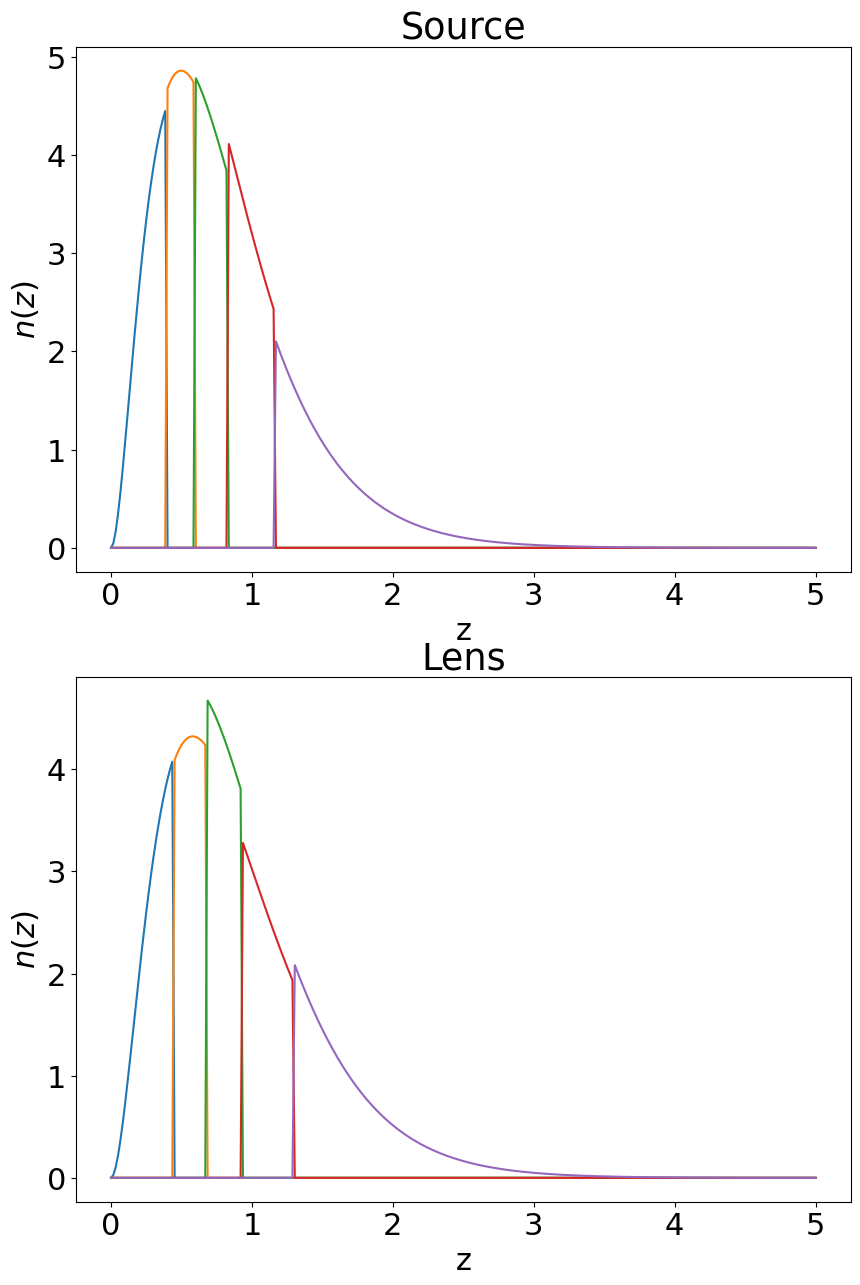

In [4]:
z = np.linspace(0,5, 300)
fig, ax = plt.subplots(2,1, figsize=(10,15))
for i in range(5):
    ax[0].plot(z, nzs_s[i](z), label='Bin '+str(i+1))
    ax[1].plot(z, nzs_l[i](z), label='Bin '+str(i+1))
    ax[0].set_title('Source')
    ax[1].set_title('Lens')
    ax[0].set_ylabel(r'$n(z)$')
    ax[1].set_ylabel(r'$n(z)$')
    ax[0].set_xlabel(r'z')
    ax[1].set_xlabel(r'z')

In [5]:
#print(jc.scipy.integrate.romb(n_source_total, 0, .4509))

## Define utility functions that are not yet supported by jax-cosmo but useful for DES analyses 

### Specify standard input parameter(s)

In [6]:
## The number of cosmological parameters in the parameter vector, i.e. the number of cosmo parameters we vary
cosmo_param_nr=4

In [7]:
def plot_contours(fisher, pos, inds, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip


## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo, ia, m_s, dz_s, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    A, eta = ia
    m1, m2, m3, m4, m5 = m_s
    dz1_s, dz2_s, dz3_s, dz4_s, dz5_s = dz_s
    b1, b2, b3, b4, b5 = b_l
    dz1_l, dz2_l, dz3_l, dz4_l, dz5_l = dz_l
    return np.array([ 
        # Cosmological parameters [Omega_c, #Omega_b#, h, sigma8, ns, gamma] 
        cosmo.Omega_c, #cosmo.Omega_b,
        cosmo.h, cosmo.sigma8, cosmo.n_s,# cosmo.gamma,
        # Source - Galaxy IA
        A, eta,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4, m5, 
        # Source - Photometric redshift calibration systematics
        dz1_s, dz2_s, dz3_s, dz4_s, dz5_s,
        # Lens - Galaxy bias
        b1, b2, b3, b4, b5,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l, dz5_l
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    A = params[cosmo_param_nr]
    eta = params[cosmo_param_nr+1]
    m1,m2,m3,m4,m5 = params[cosmo_param_nr+2:cosmo_param_nr+7]
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s = params[cosmo_param_nr+7:cosmo_param_nr+12]
    b1,b2,b3,b4,b5 = params[cosmo_param_nr+12:cosmo_param_nr+17]
    dz1_l,dz2_l,dz3_l,dz4_l,dz5_l = params[cosmo_param_nr+17:cosmo_param_nr+23]
    return cosmo, [A, eta], [m1,m2,m3,m4,m5], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s], [b1,b2,b3,b4,b5], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l]

## Uncomment these lines below to double-check the two function behaviors
#p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              #[1., 2.,0.62],[0.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0])
#print(unpack_params_vec(p))

## Define fiducial cosmological parameters and systematics parameters

### Define fiducial cosmology

#### Specify Planck18 best-fit cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [8]:
PL18_h=0.6732
PL18_omegacdm=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.8120
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma=0.55

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [9]:
fid_cosmo = jc.Cosmology(sigma8=PL18_sigma8,
                          Omega_c=PL18_omegacdm,
                          Omega_b=PL18_omegab,
                          h=PL18_h,
                          n_s=PL18_ns,
                          w0=PL18_w0, Omega_k=PL18_omegak, wa=PL18_wa)#, gamma=GR_gamma)

### Specify systematic parameters for source galaxies

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have four parameters $m^i$ for four redshift bins of the source samples.
For their fiducial values, we use the priors in Table 1 of S. S. Boruah, et. al. ([arXiv:2203.06124v1](https://arxiv.org/abs/2203.06124)). They can be varied within reasonable ranges.

In [10]:
m_s = [0,0,0,0,0]

#### Photo-z calibration systematics

Similarly, we have four parameters $\Delta z_s^i$ for four redshift bins of the source samples. We again use the priors in Table 1 of Boruah, et. al. ([arXiv:2203.06124v1](https://arxiv.org/abs/2203.06124)). They can also be varied within reasonable ranges.

In [11]:
dz_s = [0.0,0.0,0.0,0.0,0.0]

#### Intrinsic Alignment (of source galaxies)

We use the DES NLA model for IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [12]:
A0, eta = [.36, 1.66]
z0 = .62

### Specify systematic parameters for lens galaxies

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

Here, we have five parameters $\Delta z_l^i$ for five redshift bins of the lens samples. For the fiducial value, we use the priors in Table 1 of Boruah, et. al. ([arXiv:2203.06124v1](https://arxiv.org/abs/2203.06124)).

In [13]:
dz_l = [0,0,0,0,0]

#### Galaxy bias systematics

Here we take the fiducial values for the linear galaxy bias parameters $b^i_l$ of lens galaxies from the priors in Table 1 of Boruah, et. al. ([arXiv:2203.06124v1](https://arxiv.org/abs/2203.06124)).

In [14]:
b_l = [1.24, 1.36, 1.47, 1.60, 1.76]

### Pack a parameter vector including both cosmological and systematic parameters

In [15]:
fid_params = get_params_vec(fid_cosmo,
                            [A0, eta],
                            m_s,
                            dz_s,
                            b_l,
                            dz_l)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Specify standard input parameter(s) for the function

In [16]:
## Specify a range of multipole ell values
ell = np.logspace(1,3)

### Put everything together and define the ```jax-cosmo``` function using just-in-time compilations

Note that here we specify the fiducial lens sample as MagLim. We include all defined sources of systematics and their associated nuisance parameters in the computation.

In [17]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l,  dz_l = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=PL18_omegab,
                         Omega_k=PL18_omegak,
                         h=cosmo_params[1],
                         sigma8=cosmo_params[2], 
                         n_s=cosmo_params[3],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

### Call the function for the first time, so there will be some waiting for compilation

In [18]:
means = compute_3x2pt_mean(fid_params,nzs_s)
%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

338 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(np.isnan(means))

[False False False ... False False False]


(1e-14, 0.001)

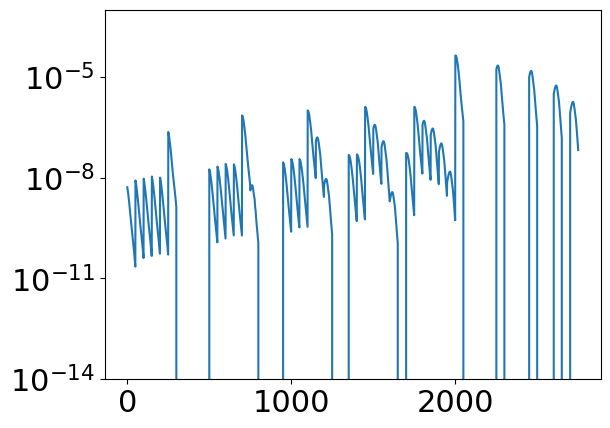

In [19]:
fig, ax = plt.subplots()
ax.semilogy(np.abs(means))
ax.set_ylim(1e-14,1e-3)

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function

Again set the fiducial lens sample to MagLim and include all sources of systematics for lens and source galaxy samples, as above, for consistency.

In [20]:
def compute_gaussian_covariance(params,nzs_source,nzs_lens=nzs_l,ell=ell,f_sky=0.25, zpivot_ia=z0):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
    ## First unpack parameter vector
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)  

    ## Define cosmology
    cosmo = jc.Cosmology(Omega_c=cosmo_params[0], 
                         Omega_b=PL18_omegab,
                         Omega_k=PL18_omegak,
                         h=cosmo_params[1],
                         sigma8=cosmo_params[2], 
                         n_s=cosmo_params[3],
                         w0=PL18_w0, wa=PL18_wa)#, gamma = cosmo_params[4])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b)]
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov

### Call the function to get the covariance and compute its inverse

The inverse of the covariance matrix is usually referred to as the *precision matrix*.

In [21]:
cov_mat = compute_gaussian_covariance(fid_params,nzs_s, f_sky = 12300/41253)
prc_mat = np.linalg.inv(cov_mat)

## Compute the Jacobian using jax-cosmo

We wrote a function to compute the mean of the 3x2-point data vector. We can use that to compute the Jacobian using ```jax-cosmo```

In [36]:
# Defining jax-cosmo jacobian
compute_3x2pt_jac = jax.jit(jax.jacrev(compute_3x2pt_mean))

In [37]:
jacobian = compute_3x2pt_jac(fid_params,nzs_s)
#%timeit compute_3x2pt_jac(fid_params,nzs_s).block_until_ready()

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 3483845326160 bytes.

In [ ]:
print(jacobian)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
print(np.array_equal(np.isnan(prc_mat), np.full(prc_mat.shape, False)))
print(np.array_equal(np.isnan(means), np.full(means.shape, False)))
print(np.array_equal(np.isnan(jacobian), np.full(jacobian.shape, False)))

True
True
False


## Compute Fisher matrix

Putting the mean and covariance together, we can now compute the Fisher matrix.
NOTE: This is, strictly speaking, only valid for Gaussian likelihoods. With ```jax-cosmo``` there is another way to compute the Fisher matrix wherein users manually define their likelihood. We will explore it below as a double-check.

In [25]:
## Take the matrix product
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

(26, 26)


In [26]:
print(fisher)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan]
 [nan nan nan nan n

```fisher``` is the full Fisher matrix. Below we can plot the whole matrix for a quick visual inspection. There should be no complain about any ```NaN``` of ```Inf``` when estimating the contours.

NOTE: This can take a while for a large Fisher matrix.

In [ ]:
fig= plt.figure(figsize=(fisher.shape[0], fisher.shape[1]))
plt.rcParams.update({
    "font.size": 10})

for i in range(fisher.shape[0]):
    for j in range(fisher.shape[1]):
        if j<i:
            plt.subplot(fisher.shape[0],fisher.shape[1],i*fisher.shape[0]+j+1)
            plot_contours(fisher, fid_params, np.array([j,i]),fill=False,color='C0')

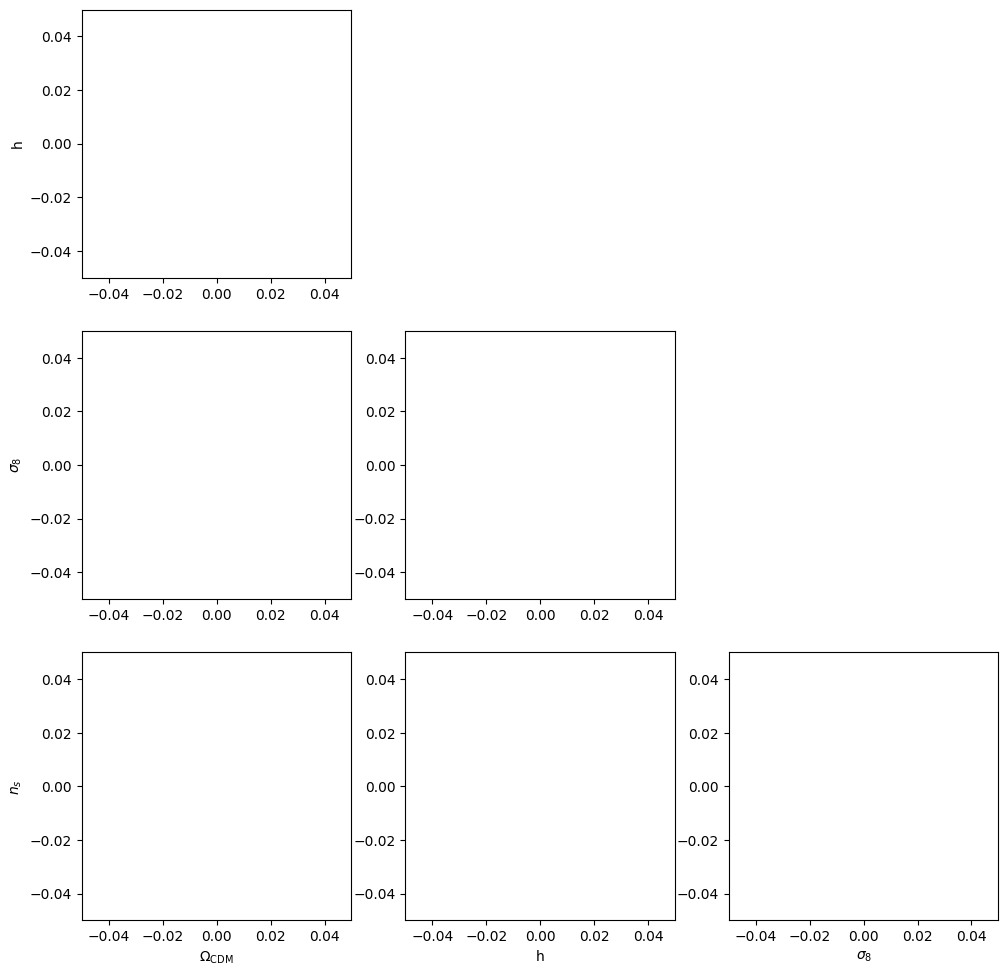

In [75]:
param_names = (r'$\Omega_\mathrm{CDM}$', 'h', r'$\sigma_8$', r'$n_s$', r'$\gamma$')
F_cosmo_only = np.linalg.inv(np.linalg.inv(fisher)[:cosmo_param_nr, :cosmo_param_nr])
fig= plt.figure(figsize=(F_cosmo_only.shape[0]*4, F_cosmo_only.shape[1]*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only.shape[0]):
    for j in range(F_cosmo_only.shape[1]):
        if j<i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==0 or i==F_cosmo_only.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only, fid_params, np.array([j,i]),fill=False,color='C0')
for i in range(cosmo_param_nr-1):
    axes[i].set_ylabel(param_names[i+1])
    axes[i+cosmo_param_nr-2].set_xlabel(param_names[i])

## Compute Fisher matrix -- Alternative Method #2, using finite differencing and the [DESC Core Cosmology Library](https://github.com/LSSTDESC/CCL) ```CCL```

To gain more confidence on the Fisher evaluation and inversion by ```jax-cosmo``` and the ```autodiff``` approach, we can cross-check results with the same outputs from the finite differencing approach using ```CCL```.

NOTE: Use a very fine sampling grid in finite differencing to ensure accuracy.

### Specify standard input parameter(s) for the function

In [58]:
zsamp = np.linspace(0.,4.,2048)
cosmo_params = [PL18_omegacdm,PL18_h,PL18_sigma8,PL18_ns]

### Define utility function(s) to use with CCL

In [59]:
# Define IA bias for DES Y1
def des_y1_ia_bias(z, A, eta, z0=0.62):
    """
    https://arxiv.org/pdf/1708.01538.pdf Sec. VII.B
    Parameters:
    -----------
    A: amplitude
    eta: redshift dependent slope
    z0: pivot redshift
    """
    return A * ((1.0 + z) / (1.0 + z0)) ** eta

### Define the function to compute the mean of the 3x2-point data vector

This is exactly the same function as above, only built with ```CCL``` and finite-differencing instead of ```jax-cosmo``` and ```autodiff```.

In [60]:
def ccl_3x2pt_mean(params,nzs_source,nzs_lens=nzs_l,ell=ell,zpivot_ia=z0,f_sky=0.25):
    """
    Returns the mean data vector provided a set of
    cosmological and nuisance parameters, using CCL
    """
    cosmo_params, (A, eta), m, dz_s, b_l, dz_l = unpack_params_vec(params)
    ## We define the cosmology
    ## here we need to explicitly convert the ArrayImpl elements into float as CCL enforces type ```double``` for these parameters
    cosmo_ccl = ccl.Cosmology(
        Omega_c=float(cosmo_params[0]), Omega_b=float(PL18_omegab),
        h=float(cosmo_params[1]), 
        sigma8=float(cosmo_params[2]),
        n_s=float(cosmo_params[3]),
        #w0=PL18_w0, wa=PL18_wa,
        #Neff=0.,
        transfer_function='eisenstein_hu', 
        matter_power_spectrum='halofit')
    
    # Build source nz with redshift systematic bias
    # Uses same function as jax-cosmo to ensure consistency
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz_s)]
    
    # We build the tracers for each redshift bins
    tracers = [ccl.WeakLensingTracer(cosmo_ccl, (zsamp, nzs_s_sys[i](zsamp)),
                                     ia_bias=(zsamp, des_y1_ia_bias(zsamp, A, eta))) for i in range(len(nzs_source))]
    # And we keep track of a term for multiplicative biases, for shear only
    m_biases = [1.+m[i] for i in range(5)]
    m_biases += [1. for i in range(5)]

    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    tracers += [ccl.NumberCountsTracer(cosmo_ccl,
                                       has_rsd=False,
                                       dndz=(zsamp, nzs_l_sys[i](zsamp)),
                                       bias=(zsamp, b_l[i]*np.ones_like(zsamp))) for i in range(len(nzs_lens))]
    n_tracers = len(tracers)
    
    # Compute all cross correlations
    cls = []
    for i in range(n_tracers):
        for j in range(i, n_tracers):
            cls.append(ccl.angular_cl(cosmo_ccl, tracers[i], tracers[j], ell)*m_biases[i]*m_biases[j])

    return np.concatenate(cls)

### Call the function to compute the mean prediction at the *same* set of fiducial parameters used above

In [61]:
ccl_means = ccl_3x2pt_mean(fid_params,nzs_s)

### Compare the mean predictions between ```CCL``` and ```jax-cosmo```

#### All range, absolute value

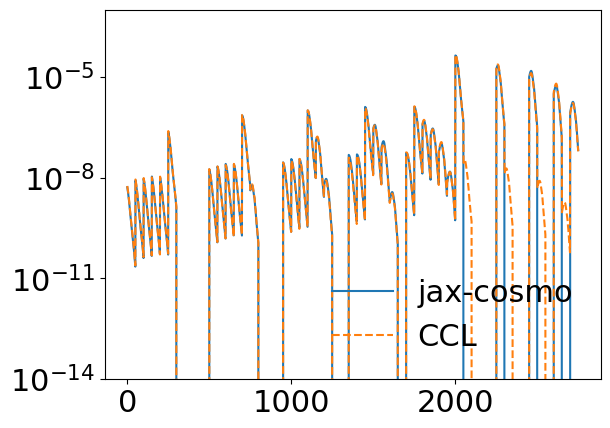

In [62]:
fig,ax=plt.subplots()
ax.semilogy(abs(means),ls='-',color='C0',label='jax-cosmo')
ax.semilogy(abs(ccl_means),ls='--',color='C1',label='CCL')
ax.set_ylim(1e-14,1e-3)
ax.legend(frameon=False)

#### High multipoles

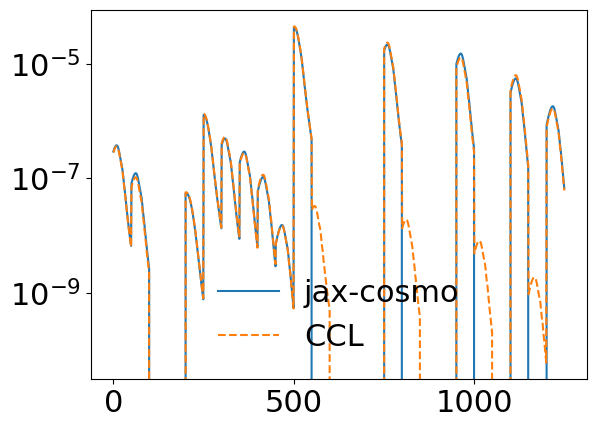

In [63]:
fig,ax=plt.subplots()
ax.semilogy(means[50*30:],ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(ccl_means[50*30:],ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

### Compute the Jacobian and Fisher matrices by finite differencing

#### Define the Jacobian

In [64]:
import numdifftools as nd
# Defining CCL jacobian
ccl_3x2pt_jac = nd.Jacobian(ccl_3x2pt_mean, step=0.002)

#### Compute Jacobian at fiducial parameter values

In [65]:
ccl_jacobian = ccl_3x2pt_jac(fid_params,nzs_s)

#### Visualization and comparison between ```CCL``` and ```jax-cosmo``` Jacobians

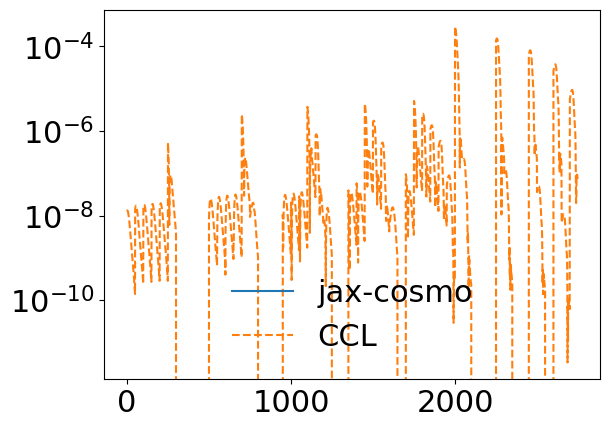

In [66]:
fig,ax=plt.subplots()
ax.semilogy(abs(jacobian[:,0]),ls='-',color='C0',label=r'jax-cosmo')
ax.semilogy(abs(ccl_jacobian[:,0]),ls='--',color='C1',label=r'CCL')
ax.legend(frameon=False)

#### Compute the Fisher matrix

We reuse the precision matrix computed earlier using ```jax-cosmo```

In [67]:
ccl_fisher = ccl_jacobian.T @ prc_mat @ ccl_jacobian
print(ccl_fisher.shape)

(26, 26)


In [68]:
print(ccl_fisher)

[[ 1.11192144e+06  1.36975058e+05  7.83583935e+05  7.94743679e+04
  -1.59971706e+03  9.41240486e+01  2.01038376e+03  2.26390736e+04
   5.56240085e+04  9.86853584e+04  1.80245214e+05  1.13821278e+04
   6.77726432e+04  7.36424755e+04  7.32570499e+04  6.51886182e+04
  -1.20551641e+05  3.79343258e+04  4.97447931e+04  6.41604788e+04
   1.18069200e+04 -2.04605953e+05  1.92325092e+05  2.89607641e+04
  -8.22490502e+04  4.37892556e+03]
 [ 1.36975058e+05  5.49530837e+04  2.57636438e+05  3.75443111e+04
  -1.01253305e+02  4.55167388e+00  4.45699150e+01  3.52134844e+02
   7.71645139e+02  1.23827173e+03  1.29819607e+03  4.48714818e+02
   1.47880209e+03  1.24874484e+03  1.26180979e+03  6.19127593e+02
   3.75578814e+04  3.34561617e+04  1.83821900e+04  1.35280057e+04
  -2.18562374e+03 -9.97629252e+04 -4.23588026e+04 -1.58513843e+04
  -2.04717880e+04  4.14487692e+03]
 [ 7.83583935e+05  2.57636438e+05  5.61418963e+06 -1.64439599e+05
  -1.04759725e+03 -4.87948442e+01  9.92042305e+02  4.32616956e+03
   6.0

### Compare the Fisher matrices from ```CCL``` and ```jax-cosmo```

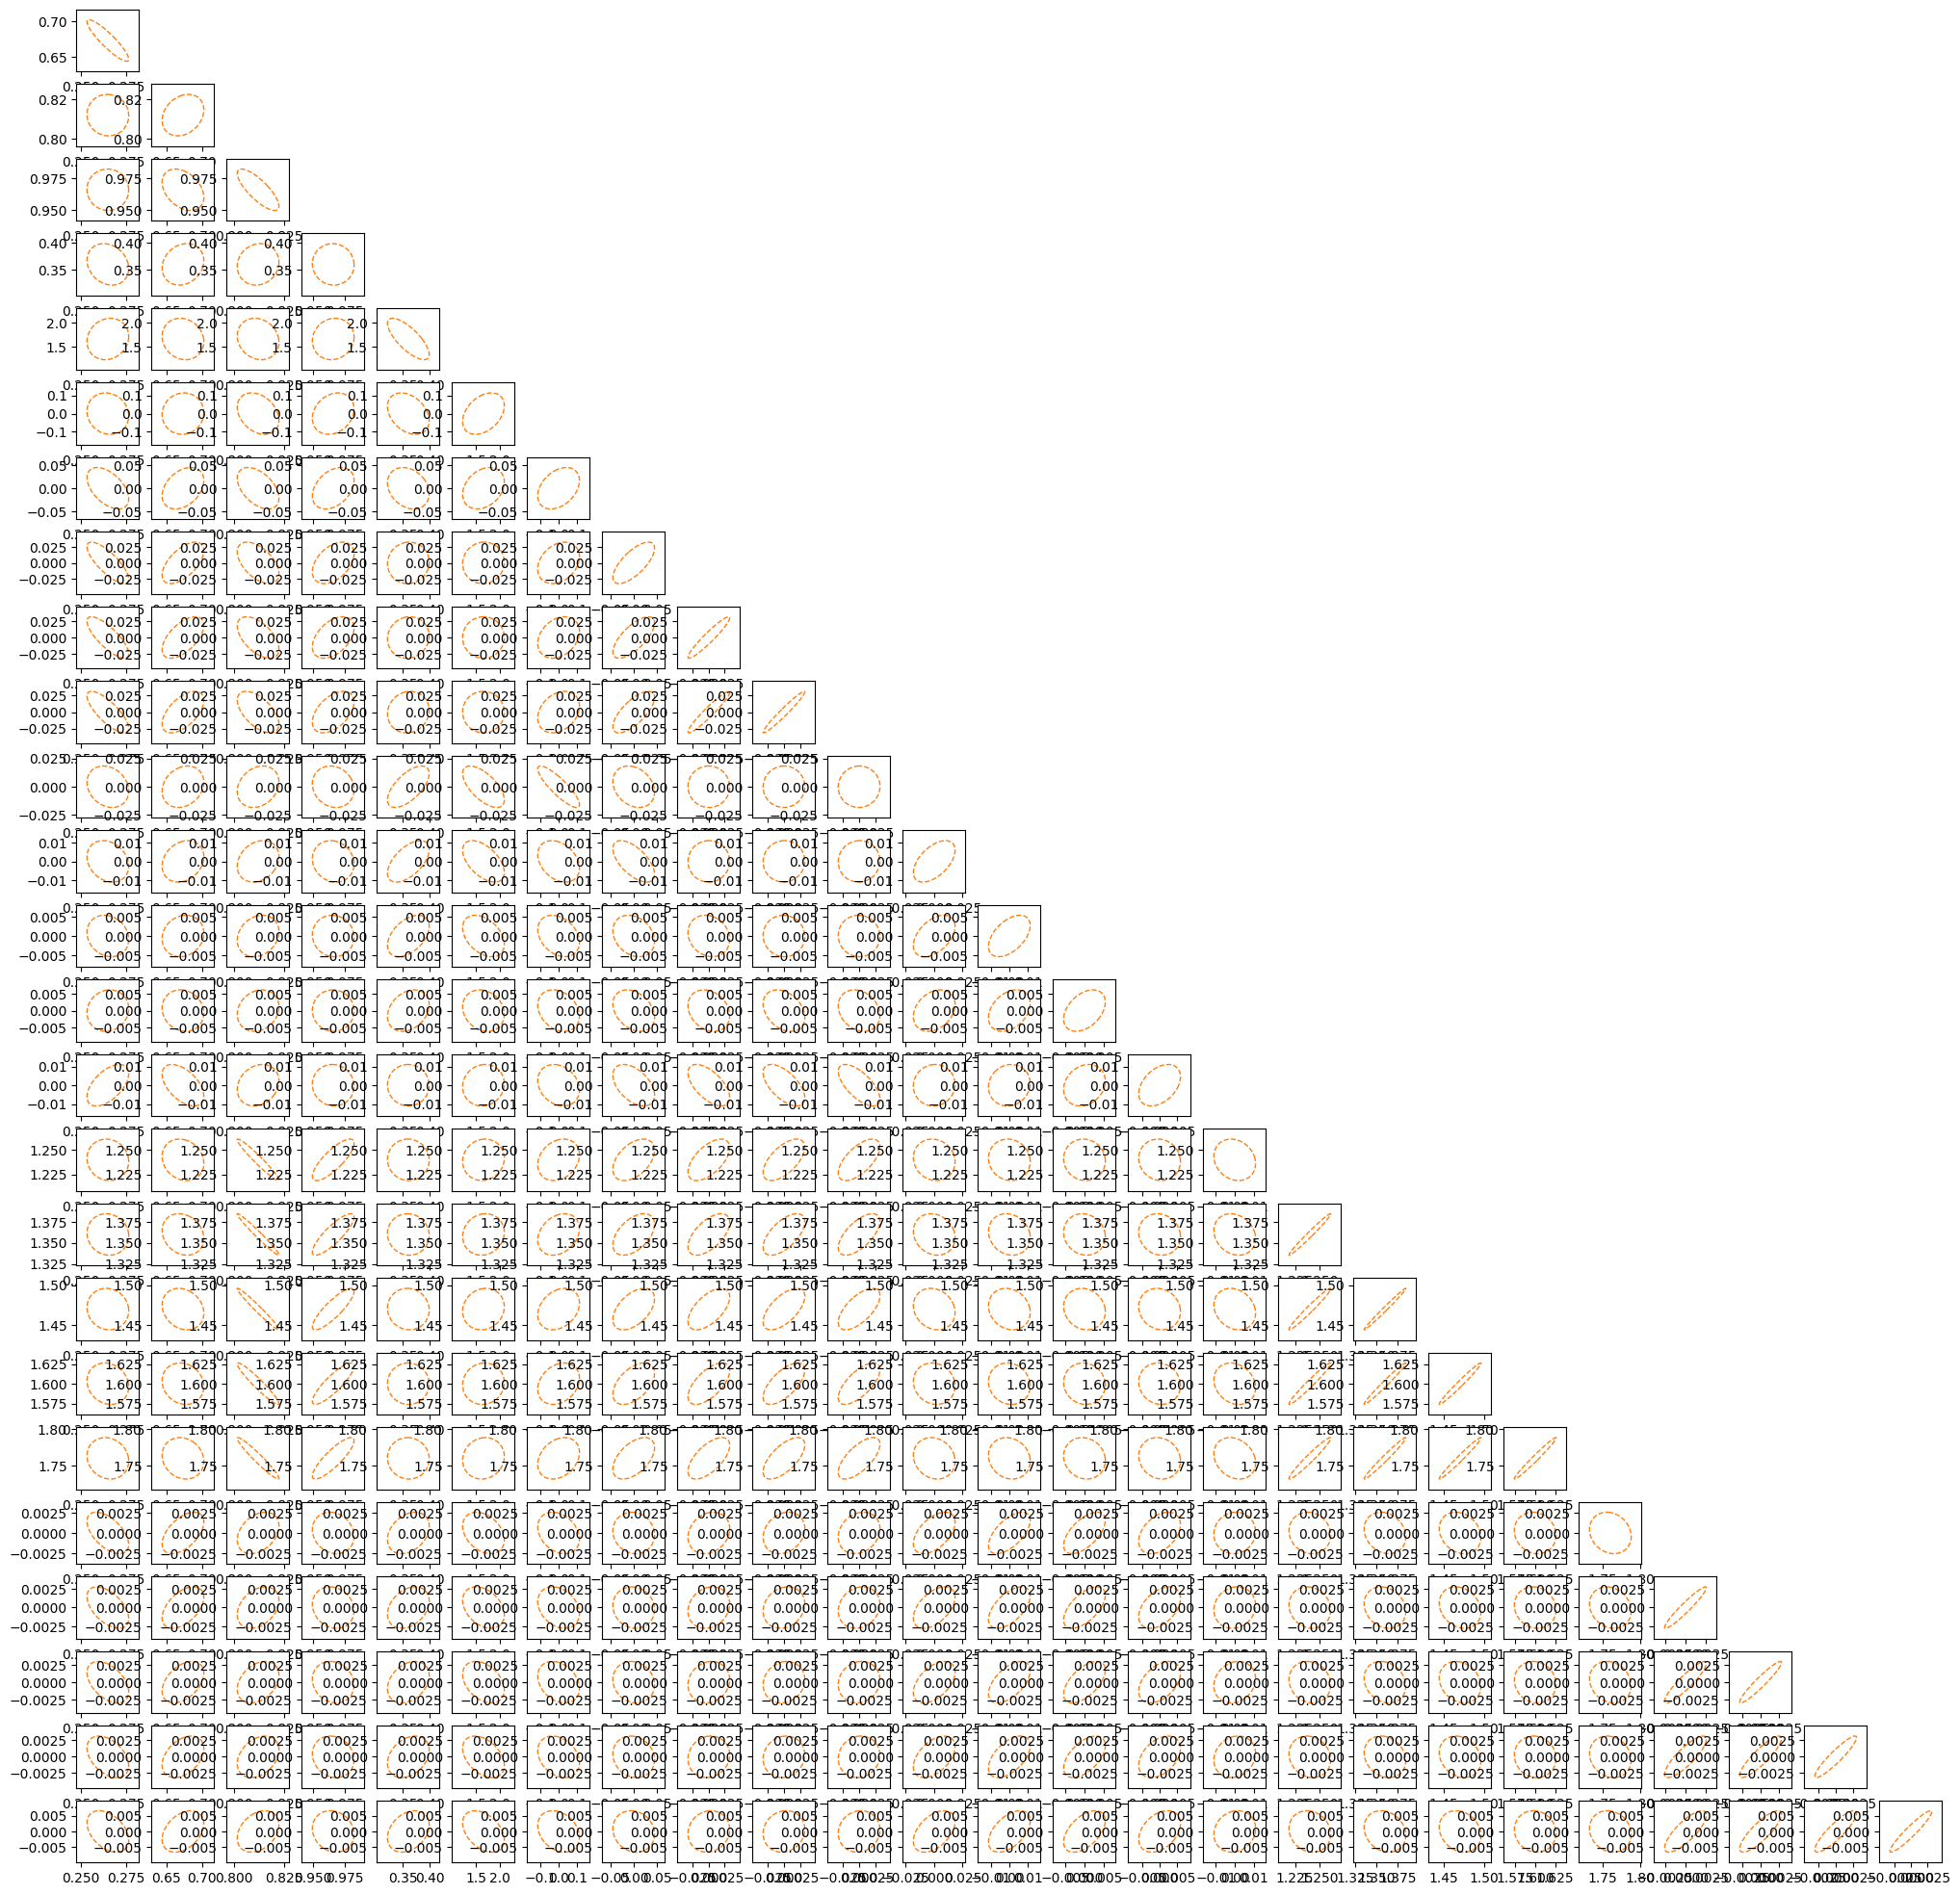

In [69]:
fig= plt.figure(figsize=(ccl_fisher.shape[0], ccl_fisher.shape[1]))
plt.rcParams.update({
    "font.size": 10})

for i in range(ccl_fisher.shape[0]):
    for j in range(ccl_fisher.shape[1]):
        if j<i:
            plt.subplot(ccl_fisher.shape[0],ccl_fisher.shape[1],i*ccl_fisher.shape[0]+j+1)
            #plot_contours(fisher, fid_params, np.array([j,i]),fill=False,ls='-',color='C0')
            plot_contours(ccl_fisher, fid_params, np.array([j,i]),fill=False,ls='--',color='C1')

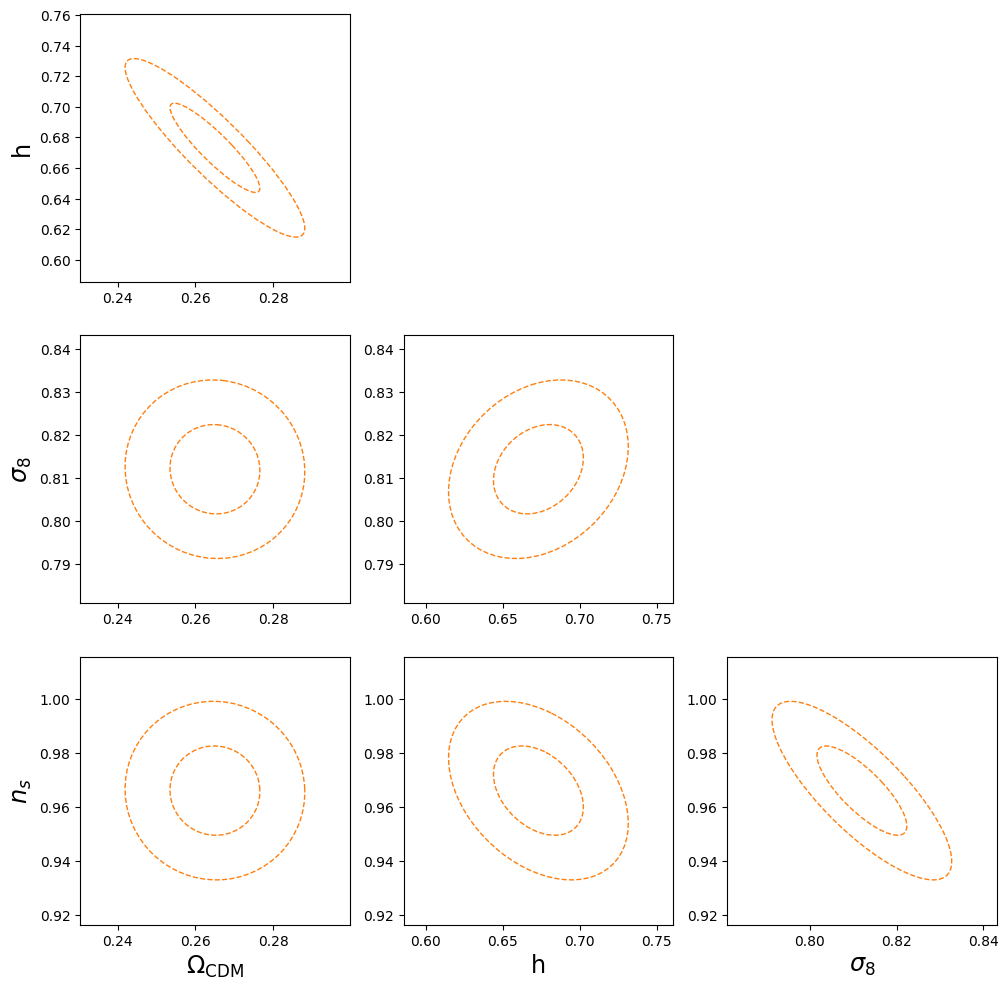

In [71]:
param_names = (r'$\Omega_\mathrm{CDM}$', 'h', r'$\sigma_8$', r'$n_s$')
F_cosmo_only = np.linalg.inv(np.linalg.inv(ccl_fisher)[:cosmo_param_nr, :cosmo_param_nr])
fig= plt.figure(figsize=(F_cosmo_only.shape[0]*4, F_cosmo_only.shape[1]*4))
plt.rcParams.update({
    "font.size": 10})

axes = []

for i in range(F_cosmo_only.shape[0]):
    for j in range(F_cosmo_only.shape[1]):
        if j<i:
            ax = plt.subplot(F_cosmo_only.shape[0],F_cosmo_only.shape[1],i*F_cosmo_only.shape[0]+j+1)
            if j==0 or i==F_cosmo_only.shape[0]-1:
                axes.append(ax)
            plot_contours(F_cosmo_only, fid_params, np.array([j,i]),fill=False, nstd=1, color='C1', ls='--')
            plot_contours(F_cosmo_only, fid_params, np.array([j,i]),fill=False, nstd=2, color='C1', ls='--')
for i in range(cosmo_param_nr-1):
    axes[i].set_ylabel(param_names[i+1], fontsize='xx-large')
    axes[i+cosmo_param_nr-2].set_xlabel(param_names[i], fontsize='xx-large')